# Projet 5 : Catégorisez automatiquement des questions
## Contexte et objectifs
Le site Stackoverflow permet de poser des questions sur le thème de la programmation informatique. Afin de classifier les questions, les utilisateurs doivent renseigner des tags afin de retrouver plus facilement les questions. Afin d'aider les utilisateurs, le but du projet est de proposer des suggestions de tags en fonction du contenu de la question.  
Après avoir exploré les données et tester différents modèles pour segmenter les données, un code sera déployer afin de créer une API utilisable par Stackoverflow
## Notebook d'explorations des données
La base de données initiale a été créée à partir d'un import de l'outil "StackExchange Data Explorer" regroupant des données du site.  
La requête SQL utilisée pour récupérer les données est la suivante :  
SELECT TOP 500000 Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount  
FROM Posts  
WHERE PostTypeId = 1 AND ViewCount > 10 AND FavoriteCount > 10  
AND Score > 5 AND AnswerCount > 0 AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5

## Modules Python

In [51]:
import numpy as np
import pandas as pd
import nltk
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
try : 
    import pyLDAvis.sklearn
except : 
    !pip install pyLDAvis
    import pyLDAvis.sklearn
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
pyLDAvis.enable_notebook()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [52]:
# Si google colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Chargement des données

In [54]:
#DATA = pd.read_csv('QueryResults.csv')
DATA = pd.read_csv("gdrive/Othercomputers/Mon ordinateur portable/P5_stackoverflow/QueryResults.csv")

In [55]:
DATA.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,SQL Server 2008 Full Text Search (FTS) versus ...,<p>I know there have been questions in the pas...,<sql-server><sql-server-2008><full-text-search...,499247,40,18582,26,5
1,XML Serialization and Inherited Types,"<p>Following on from my <a href=""https://stack...",<c#><xml><inheritance><serialization><xml-seri...,20084,86,56816,42,7
2,MyISAM versus InnoDB,<p>I'm working on a projects which involves a ...,<mysql><database><performance><innodb><myisam>,20148,887,301985,390,25
3,Recommended SQL database design for tags or ta...,<p>I've heard of a few ways to implement taggi...,<sql><database-design><tags><data-modeling><ta...,20856,325,118552,307,6
4,Specifying a mySQL ENUM in a Django model,<p>How do I go about specifying and using an E...,<python><mysql><django><django-models><enums>,21454,99,61572,21,9


In [56]:
print(f"Nombre de lignes dans la base de données : {len(DATA)}")
print(f"Nombre de variables dans la base de données : {len(DATA.columns)}")
print(f"Type des variables :")
print(DATA.dtypes)

Nombre de lignes dans la base de données : 27338
Nombre de variables dans la base de données : 8
Type des variables :
Title            object
Body             object
Tags             object
Id                int64
Score             int64
ViewCount         int64
FavoriteCount     int64
AnswerCount       int64
dtype: object


## Transformation des variables textes

### Tags
Pour pouvoir manipuler les tags plus facilement, une liste est créée regroupant les tags pour chaque questions

In [57]:
tags_tokenizer = nltk.SExprTokenizer(parens='<>')
DATA['Tags_list'] = DATA['Tags'].apply(tags_tokenizer.tokenize)
DATA['Tags_list']

0        [<sql-server>, <sql-server-2008>, <full-text-s...
1        [<c#>, <xml>, <inheritance>, <serialization>, ...
2        [<mysql>, <database>, <performance>, <innodb>,...
3        [<sql>, <database-design>, <tags>, <data-model...
4        [<python>, <mysql>, <django>, <django-models>,...
                               ...                        
27333    [<.net>, <visual-studio>, <unit-testing>, <vis...
27334    [<java>, <maven>, <intellij-idea>, <apache-spa...
27335    [<windows>, <keyboard-shortcuts>, <windows-10>...
27336          [<java>, <spring>, <maven>, <jaxb>, <wsdl>]
27337         [<c++>, <c++11>, <gcc>, <boost>, <pthreads>]
Name: Tags_list, Length: 27338, dtype: object

### Body
Le texte du corps de la question est procédé de manière à retirer les balises \<p\> et \</p> et ensuite de récupérer chaque mot en supprimant la ponctuation. 
Les numéros sont également supprimmés puisqu'ils n'apportent pas de sens à priori.


In [58]:
def tokenize_body(txt):
    #txt = re.sub(r'\d+', '', txt)
    txt = ''.join([i for i in txt if not i.isdigit()])
    txt = re.sub(r'_+', ' ', txt)
    tag_tokenizer = nltk.RegexpTokenizer(r'</?(?:b|p)>', gaps=True)
    txt_tokenizer = nltk.RegexpTokenizer(r'\w+')
    return txt_tokenizer.tokenize(' '.join(tag_tokenizer.tokenize(txt.lower())))

In [59]:
DATA["Body_words"] = DATA['Body'].apply(tokenize_body)
DATA["Body_words"]

0        [i, know, there, have, been, questions, in, th...
1        [following, on, from, my, a, href, https, stac...
2        [i, m, working, on, a, projects, which, involv...
3        [i, ve, heard, of, a, few, ways, to, implement...
4        [how, do, i, go, about, specifying, and, using...
                               ...                        
27333    [update, adding, a, the, discovery, runner, in...
27334    [i, am, running, into, an, issue, with, my, ma...
27335    [learning, debugging, in, phpstorm, and, keep,...
27336    [i, am, trying, to, use, maven, to, generate, ...
27337    [pre, code, include, lt, iostream, gt, include...
Name: Body_words, Length: 27338, dtype: object

### Titre 

In [62]:
def tokenize_title(txt) :
   title_tokenizer = nltk.RegexpTokenizer(r'\w+')
   return  title_tokenizer.tokenize(txt.lower())

In [63]:
DATA['Title_words'] = DATA['Title'].apply(tokenize_title)
DATA['Title_words']

0        [sql, server, 2008, full, text, search, fts, v...
1              [xml, serialization, and, inherited, types]
2                                 [myisam, versus, innodb]
3        [recommended, sql, database, design, for, tags...
4        [specifying, a, mysql, enum, in, a, django, mo...
                               ...                        
27333    [why, is, the, visual, studio, 2015, 2017, 201...
27334    [failed, to, read, artifact, descriptor, intel...
27335               [ctrl, alt, f8, disconnects, displays]
27336    [how, to, use, a, class, customization, to, re...
27337    [when, g, static, link, pthread, cause, segmen...
Name: Title_words, Length: 27338, dtype: object

## Transformation de la base de données
La base de données est transformée afin de créer une ligne par tag.  

In [64]:
DATA_split_tags = DATA.explode("Tags_list")
DATA_split_tags

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,Tags_list,Body_words,Title_words
0,SQL Server 2008 Full Text Search (FTS) versus ...,<p>I know there have been questions in the pas...,<sql-server><sql-server-2008><full-text-search...,499247,40,18582,26,5,<sql-server>,"[i, know, there, have, been, questions, in, th...","[sql, server, 2008, full, text, search, fts, v..."
0,SQL Server 2008 Full Text Search (FTS) versus ...,<p>I know there have been questions in the pas...,<sql-server><sql-server-2008><full-text-search...,499247,40,18582,26,5,<sql-server-2008>,"[i, know, there, have, been, questions, in, th...","[sql, server, 2008, full, text, search, fts, v..."
0,SQL Server 2008 Full Text Search (FTS) versus ...,<p>I know there have been questions in the pas...,<sql-server><sql-server-2008><full-text-search...,499247,40,18582,26,5,<full-text-search>,"[i, know, there, have, been, questions, in, th...","[sql, server, 2008, full, text, search, fts, v..."
0,SQL Server 2008 Full Text Search (FTS) versus ...,<p>I know there have been questions in the pas...,<sql-server><sql-server-2008><full-text-search...,499247,40,18582,26,5,<lucene>,"[i, know, there, have, been, questions, in, th...","[sql, server, 2008, full, text, search, fts, v..."
0,SQL Server 2008 Full Text Search (FTS) versus ...,<p>I know there have been questions in the pas...,<sql-server><sql-server-2008><full-text-search...,499247,40,18582,26,5,<lucene.net>,"[i, know, there, have, been, questions, in, th...","[sql, server, 2008, full, text, search, fts, v..."
...,...,...,...,...,...,...,...,...,...,...,...
27337,"when g++ static link pthread, cause Segmentati...",<pre><code>#include &lt;iostream&gt;\n#include...,<c++><c++11><gcc><boost><pthreads>,35116327,35,16473,25,2,<c++>,"[pre, code, include, lt, iostream, gt, include...","[when, g, static, link, pthread, cause, segmen..."
27337,"when g++ static link pthread, cause Segmentati...",<pre><code>#include &lt;iostream&gt;\n#include...,<c++><c++11><gcc><boost><pthreads>,35116327,35,16473,25,2,<c++11>,"[pre, code, include, lt, iostream, gt, include...","[when, g, static, link, pthread, cause, segmen..."
27337,"when g++ static link pthread, cause Segmentati...",<pre><code>#include &lt;iostream&gt;\n#include...,<c++><c++11><gcc><boost><pthreads>,35116327,35,16473,25,2,<gcc>,"[pre, code, include, lt, iostream, gt, include...","[when, g, static, link, pthread, cause, segmen..."
27337,"when g++ static link pthread, cause Segmentati...",<pre><code>#include &lt;iostream&gt;\n#include...,<c++><c++11><gcc><boost><pthreads>,35116327,35,16473,25,2,<boost>,"[pre, code, include, lt, iostream, gt, include...","[when, g, static, link, pthread, cause, segmen..."


## Eploration

### Tags

#### Nombre de tags

In [65]:
print(f"Nombre de Tags = {len(DATA_split_tags['Tags_list'].unique())}") 

Nombre de Tags = 12467


La base de données contient un très grand nombre de tags différents

#### tags les plus fréquents

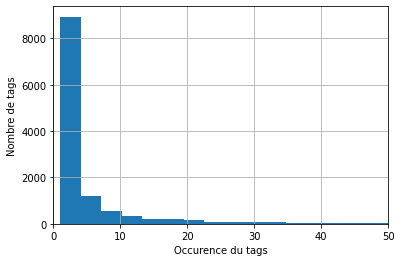

In [66]:
count = DATA_split_tags['Tags_list'].value_counts()
fig, ax = plt.subplots()
count.hist(bins=1000, ax=ax)
ax.set_xlim(0,50)
ax.set_xlabel("Occurence du tags")
ax.set_ylabel("Nombre de tags")
plt.show()

In [67]:
count

<java>            3075
<python>          3071
<javascript>      2712
<c#>              2659
<ios>             2399
                  ... 
<raw-ethernet>       1
<redundancy>         1
<xcconfig>           1
<butterknife>        1
<video-card>         1
Name: Tags_list, Length: 12467, dtype: int64

L'histogramme montre clairement qu'un grand nombre de tags ne sont que très peu utilisés. Afin de pouvoir catégoriser correctement chaque tag, il est important d'avoir un nombre suffisant de questions où il est utilisé.  
On peut donc déterminer arbitrairement qu'un tag doit être utilisé au moins 20 fois pour pouvoir être caractériser correctement.  
On supprime donc les tags ne respectant pas cette condition.

In [68]:
print(f"Nombre de tag après nettoyage : {len(count[count >= 20])}")

Nombre de tag après nettoyage : 1032


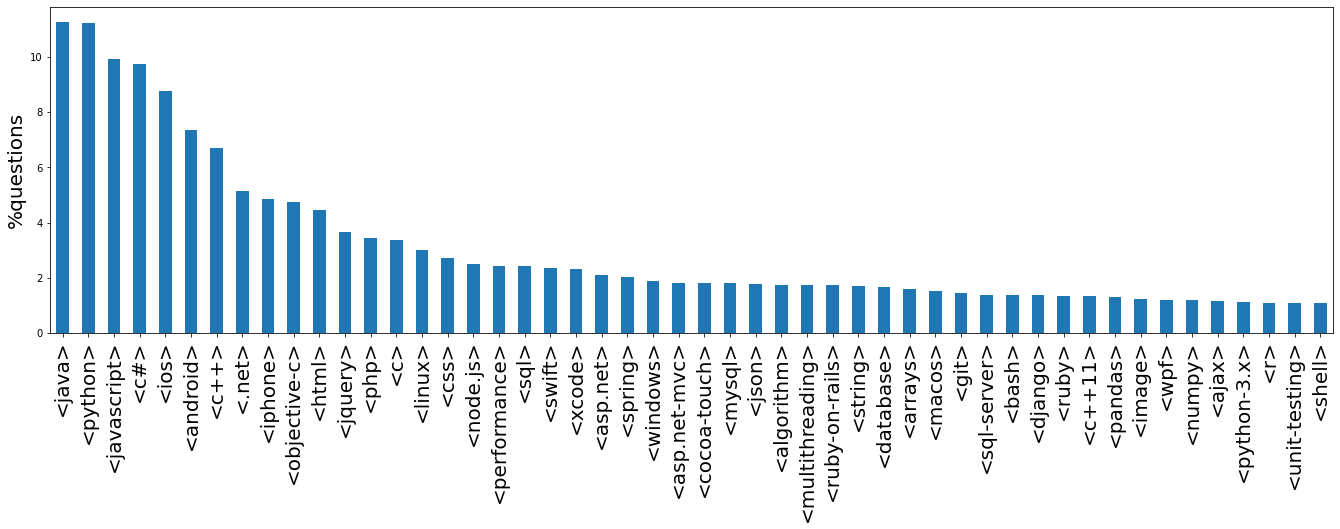

In [69]:
freq = count/len(DATA)*100
fig, ax = plt.subplots(figsize=(23,6))
freq[:50].plot(kind='bar', ax=ax)
ax.set_ylabel("%questions")
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.show()
most_frequent_tags = freq[:50].index

En représentant les tags les plus fréquemment utilisés, on remarque que la grande majorité se rapporte à des langages de programmation ou des système d'exploitation.  
On peut aussi affirmer que les langages les plus populaires des utilisateurs de Stackoverflow sont Java, Python, Javascript et C.

#### suppression des tags peu utilisés

In [70]:
def clean_tag_rm(l, rm_list=[]) :
    return list(set(l)-set(rm_list))
def clean_tag_keep(l, tags=[]) :
    return [t for t in l if t in tags]

In [71]:
rm_tags = count[count<20].index
DATA['Tags_list'] = DATA['Tags_list'].apply(clean_tag_rm, rm_list=rm_tags)

#### conservation uniquement des tags les plus utilisés
Une autre approche est réalisée, en ne concervant uniquement les tags les plus fréquents. Cela va permettre de faciliter la segmentation par la suite.

In [72]:
DATA_20tags = DATA.copy(deep=True)
tags = freq[:20]
DATA_20tags['Tags_list'] = DATA_20tags['Tags_list'].apply(clean_tag_keep, tags=tags)

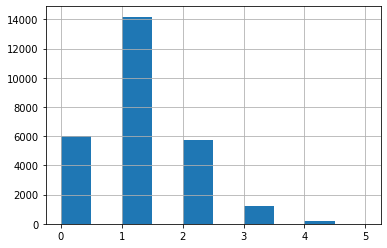

In [73]:
DATA_20tags['nTags'] = DATA_20tags['Tags_list'].apply(len)
DATA_20tags['nTags'].value_counts()
DATA_20tags['nTags'].hist()

La conservation d'uniquement 20tags induit la déclassification d'environ 6000 questions.

In [74]:
DATA_50tags = DATA.copy(deep=True)
tags = freq[:50]
DATA_50tags['Tags_list'] = DATA_50tags['Tags_list'].apply(clean_tag_keep, tags=tags)

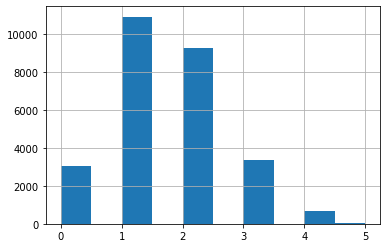

In [75]:
DATA_50tags['nTags'] = DATA_50tags['Tags_list'].apply(len)
DATA_50tags['nTags'].value_counts()
DATA_50tags['nTags'].hist()

Conserver 50 tags permet de ne décatégoriser que 3000 questions.

In [76]:
DATA_20tags = DATA_20tags.drop(DATA_20tags[DATA_20tags['nTags']==0].index)
DATA_50tags = DATA_50tags.drop(DATA_50tags[DATA_50tags['nTags'] == 0].index)

### Exploration des mots utilisés

#### Variable regroupant tous les mots

In [77]:
words_body = []
for l in DATA['Body_words'].values :
    words_body.extend(l)
print(f"Nombre de mots utilisé dans les questions : {len(words_body)}")
words_body = pd.Series(data=words_body)

Nombre de mots utilisé dans les questions : 5611556


In [78]:
words_title = []
for l in DATA['Title_words'].values :
    words_title.extend(l)
print(f"Nombre de mots utilisé dans les titres : {len(words_title)}")
words_title = pd.Series(data=words_title)

Nombre de mots utilisé dans les titres : 249791


#### Nombre de mots dans le vocabulaire

In [79]:
print(f"Nombre de mots différents dans le vocabulaire : {len(words_body.unique())}")
print(f"Nombre de mots différents dans le titre : {len(words_title.unique())}")

Nombre de mots différents dans le vocabulaire : 108862
Nombre de mots différents dans le titre : 14705


#### distribution du nombre d'utilisation des mots

Nombre d'utilisation du mot le plus fréquent : 181797
Nombre d'utilisation du mot le moins fréquent : 1


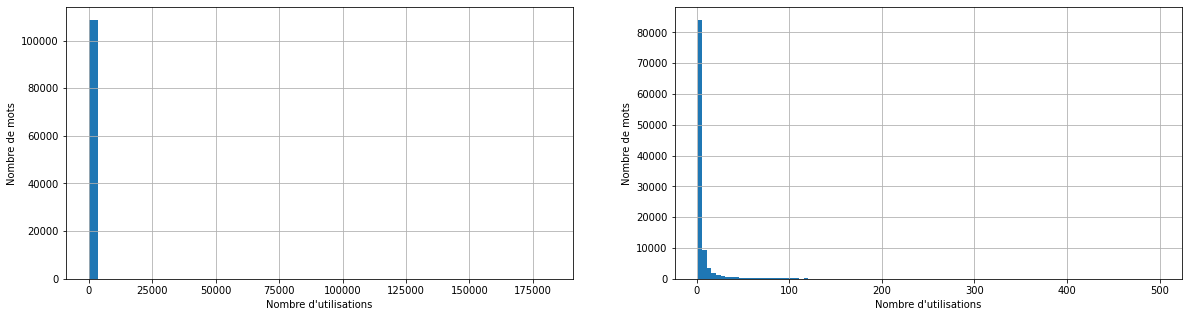

Nombre de mots utilisé moins de 1000 fois : 108141, soit 99.33769359372417
appreciated                      998
design                           997
development                      997
provide                          997
makes                            997
                                ... 
kcatransition                      1
dbusername                         1
kcamediatimingfunctioneaseout      1
hadoopfoldername                   1
xffffffa                           1
Length: 108141, dtype: int64


In [80]:
counter = words_body.value_counts()
print(f"Nombre d'utilisation du mot le plus fréquent : {counter.max()}")
print(f"Nombre d'utilisation du mot le moins fréquent : {counter.min()}")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
counter.hist(bins=50, ax=axs[0])
counter[counter<500].hist(bins=100,ax=axs[1])
for ax in axs :
    ax.set_ylabel("Nombre de mots")
    ax.set_xlabel("Nombre d'utilisations")
plt.show()
print(f"Nombre de mots utilisé moins de 1000 fois : {len(counter[counter < 1000 ])}, soit {len(counter[counter < 1000 ])/len(counter)*100}")
print(counter[counter<1000])

Beaucoup de mots ne sont pas beaucoup utilisés. Si on ne concidère que les mots utilisés moins de 1000 fois, on conserve 108153 mots soit 99.3% des mots

#### Distribution du nombre de mots par questions

In [81]:
#DATA["Body_nwords_noSW"] = DATA['Body_words_noSW'].apply(len)
DATA["Body_nwords"] = DATA['Body_words'].apply(len)
DATA_20tags['Body_nwords'] = DATA_20tags['Body_words'].apply(len)
DATA_50tags['Body_nwords'] = DATA_50tags['Body_words'].apply(len)

Suite à cette modification, il est nécessaire de recréer la base de données DATA_split_tags

In [82]:
DATA_split_tags = DATA.explode("Tags_list")

count    27338.000000
mean       205.265784
std        230.235349
min          4.000000
25%         79.000000
50%        139.000000
75%        246.000000
max       4192.000000
Name: Body_nwords, dtype: float64


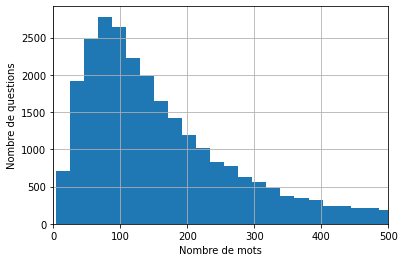

In [83]:
#print(DATA['Body_nwords_noSW'].describe())
print(DATA['Body_nwords'].describe())
fig, ax = plt.subplots()
#DATA['Body_nwords_noSW'].hist(bins=200, ax=ax)
DATA['Body_nwords'].hist(bins=200, ax=ax)
ax.set_xlim(0,500)
ax.set_ylabel('Nombre de questions')
ax.set_xlabel("Nombre de mots")
plt.show()

Cette analyse met en évidence que la majorité des questions sont composées d'environ 100 mots, mais que certaines sont beaucoup plus longues, pouvant refléter la complexiter du problème.

### analyse multivarié
Analyse de différentes metrics en fonction de chaque tags

In [84]:
def plot_anova(data, quanti_var, quali_var) :
    dat = data[pd.notnull(data[quali_var])]
    dat = dat[pd.notnull(dat[quanti_var])]

    modalites = data[quali_var].unique()
    groupes = []
    for mod in modalites : 
        groupes.append(dat[dat[quali_var]== mod][quanti_var])
    
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    fig, ax = plt.subplots(figsize=((23,5)))
    ax.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
    ax.set_ylabel(quanti_var)
    plt.xticks(rotation=90)
    plt.xticks(fontsize=20)
    plt.show()

#### ANOVA : tags principaux en fonction de la variable

variable : Score


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


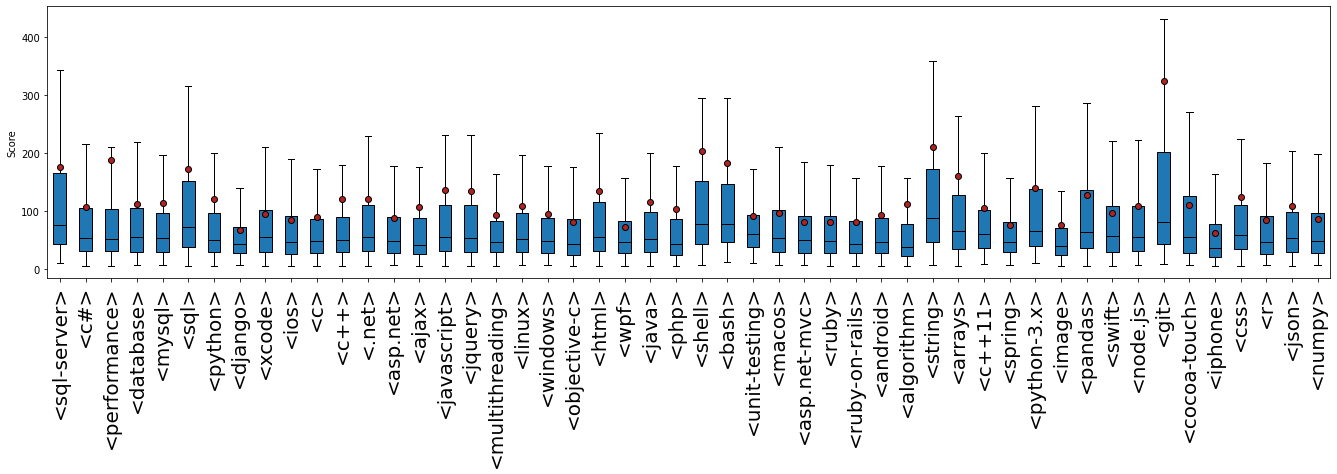

variable : ViewCount


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


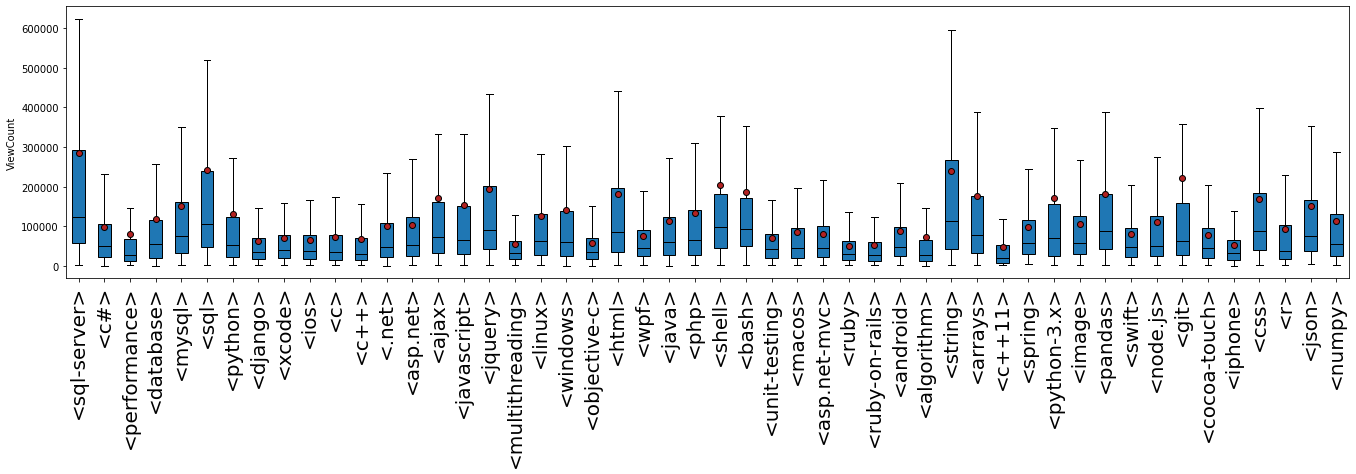

variable : FavoriteCount


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


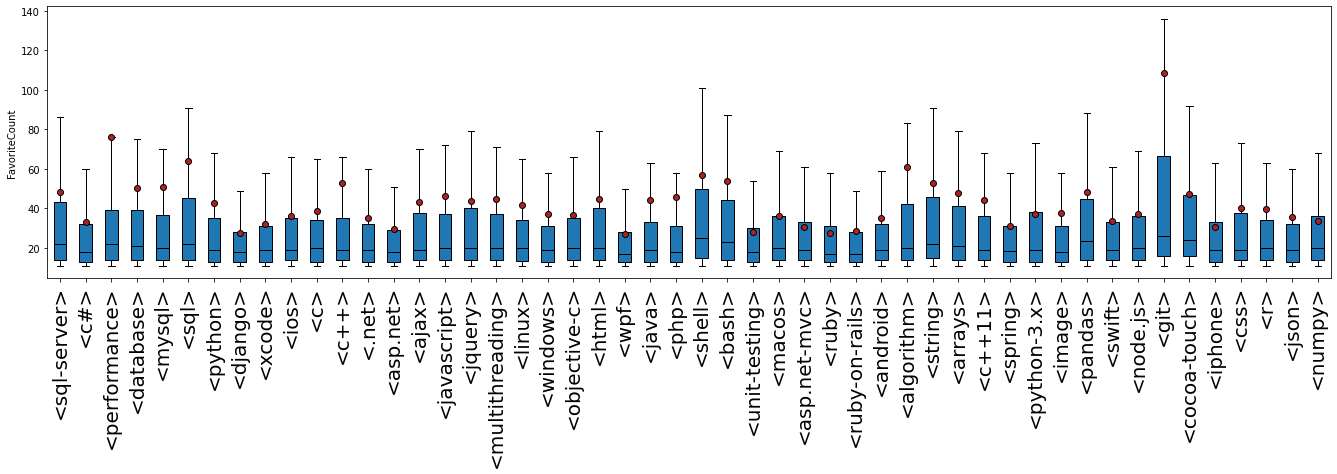

variable : AnswerCount


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


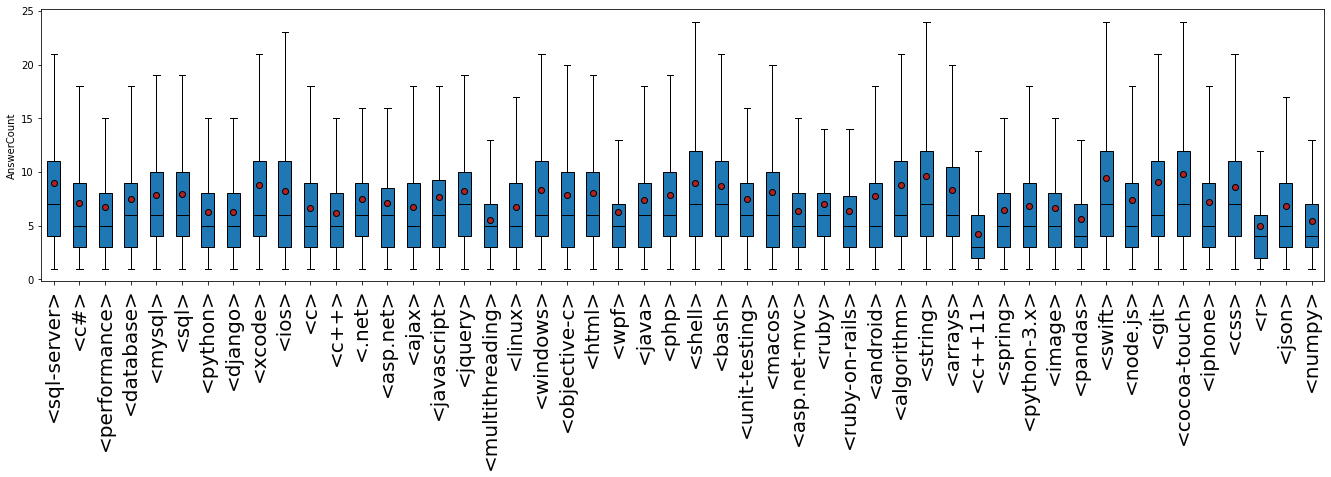

variable : Body_nwords


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


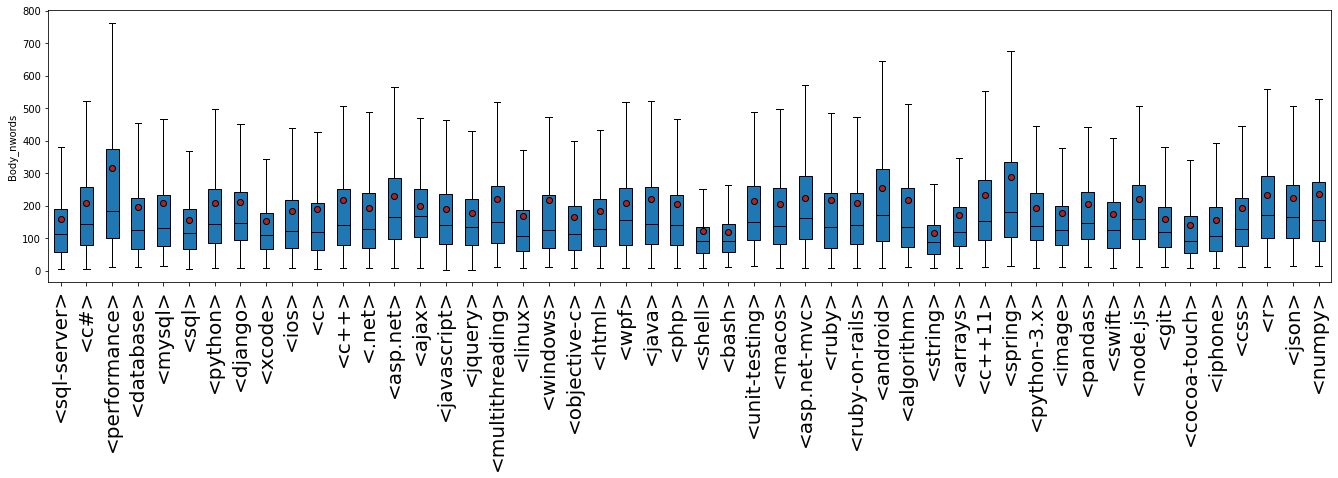

In [88]:
for variable in ['Score', 'ViewCount', 'FavoriteCount', 'AnswerCount', "Body_nwords"]:#, "Body_nwords_noSW"] :
    print("="*50)
    print(f"variable : {variable}")
    print("="*50)
    plot_anova(DATA_split_tags[DATA_split_tags['Tags_list'].isin(most_frequent_tags)], variable, "Tags_list")

Grâce à l'ANOVA, on peut remarquer que les différents tags n'ont pas des distributions simulaires des différentes variables. Il est donc possible d'observer quel tags sont les plus répondus ou les plus lus.

## Réduction de dimensions

### Lemmatisation


In [89]:
tag_map = defaultdict(lambda : nltk.corpus.wordnet.NOUN)
tag_map['J'] = nltk.corpus.wordnet.ADJ
tag_map['V'] = nltk.corpus.wordnet.VERB
tag_map['R'] = nltk.corpus.wordnet.ADV

lemmatizer = nltk.stem.WordNetLemmatizer()
def do_lemmatization(tokens, lemmatizer=None, tag_map=None) :
    out = []
    for token, tag in nltk.pos_tag(tokens) :
        out.append(lemmatizer.lemmatize(token, tag_map[tag[0]]))
    return out
    #if lemmatizer is not None :
    #    return [ lemmatizer.lemmatize(val) for val in l ]
    #else :
    #    return l
DATA['Body_words_lemmat'] = DATA['Body_words'].apply(do_lemmatization, lemmatizer=lemmatizer, tag_map=tag_map)

In [90]:
DATA_20tags['Body_words_lemmat'] = DATA_20tags['Body_words'].apply(do_lemmatization, lemmatizer=lemmatizer, tag_map=tag_map)

In [91]:
DATA_50tags['Body_words_lemmat'] = DATA_50tags['Body_words'].apply(do_lemmatization, lemmatizer=lemmatizer, tag_map=tag_map)

In [92]:
words_body_lemmat = []
for l in DATA['Body_words_lemmat'].values :
    words_body_lemmat.extend(l)
print(f"Nombre de mots utilisé dans les questions : {len(words_body_lemmat)}")
words_body_lemmat = pd.Series(data=words_body_lemmat)
print(f"Nombre de mots différents dans le vocabulaire après lemmatisation: {len(words_body_lemmat.unique())}")
print(f"Soit une différence de {len(words_body.unique()) - len(words_body_lemmat.unique())} mots ({(len(words_body.unique()) - len(words_body_lemmat.unique()))/len(words_body.unique())*100:.2f}%)")

Nombre de mots utilisé dans les questions : 5611556
Nombre de mots différents dans le vocabulaire après lemmatisation: 104629
Soit une différence de 4233 mots (3.89%)


In [93]:
DATA["Body_nwords_lemmat"] = DATA['Body_words_lemmat'].apply(len)
DATA_20tags["Body_nwords_lemmat"] = DATA_20tags['Body_words_lemmat'].apply(len)
DATA_50tags["Body_nwords_lemmat"] = DATA_50tags['Body_words_lemmat'].apply(len)

count    27338.000000
mean       205.265784
std        230.235349
min          4.000000
25%         79.000000
50%        139.000000
75%        246.000000
max       4192.000000
Name: Body_nwords_lemmat, dtype: float64


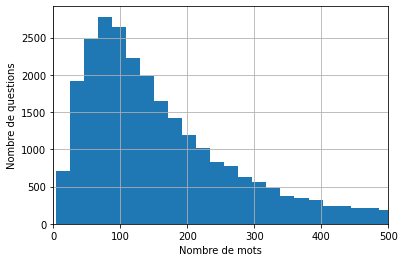

In [94]:
print(DATA['Body_nwords_lemmat'].describe())
fig, ax = plt.subplots()
DATA['Body_nwords_lemmat'].hist(bins=200, ax=ax)
ax.set_xlim(0,500)
ax.set_ylabel('Nombre de questions')
ax.set_xlabel("Nombre de mots")
plt.show()

Comme attendu la lemmatisation ne réduit pas le nombre de mots par question.
Cela permet uniquement de réduire le nombre de mots de vocabulaire

### Bags of words
On place les mots dans un sac de mots, en appliquant les filtres suivant :
- chaque mot doit être contenu dans maximum 95% des documents
- Chaque mot doit être présent au minimum deux fois dans le corpus
- le nombre de mots maximum est assez élevé pour prendre en compte l'ensemble des mots

In [96]:
#tf_vectorizer = CountVectorizer(lowercase=True, tokenizer=tokenize_body, max_df=0.95, min_df=2, max_features=10000)
def dummy(doc) :
    return doc
tf_vectorizer_all = CountVectorizer(tokenizer=dummy, preprocessor=dummy, max_df=0.95, min_df=2, max_features=100000)
bag_of_words_all = tf_vectorizer_all.fit_transform(DATA['Body_words'].values)
words_bow_all = tf_vectorizer_all.get_feature_names_out()

In [97]:
print(f"Nombre de mots présent dans le sac de mots : {len(words_bow_all)}")
print(f"Nombre de mots supprimés : {len(words_body.unique()) - len(words_bow_all)}, soit {(len(words_body.unique()) - len(words_bow_all))/len(words_body.unique())*100:.2f}%")
print(f"Mots présents dans le sac de mots : {words_bow_all}")

Nombre de mots présent dans le sac de mots : 35766
Nombre de mots supprimés : 73096, soit 67.15%
Mots présents dans le sac de mots : ['a' 'aa' 'aaa' ... 'σ' 'ω' '你好']


In [98]:
def dummy(doc) :
    return doc
tf_vectorizer_lemmat = CountVectorizer(tokenizer=dummy, preprocessor=dummy, max_df=0.95, min_df=2, max_features=100000)
bag_of_words_lemmat = tf_vectorizer_lemmat.fit_transform(DATA['Body_words_lemmat'].values)
words_bow_lemmat = tf_vectorizer_lemmat.get_feature_names_out()

In [99]:
print(f"Nombre de mots présent dans le sac de mots : {len(words_bow_lemmat)}")
print(f"Nombre de mots supprimés : {len(words_body.unique()) - len(words_bow_lemmat)}, soit {(len(words_body.unique()) - len(words_bow_lemmat))/len(words_body.unique())*100:.2f}%")
print(f"Mots présents dans le sac de mots : {words_bow_lemmat}")

Nombre de mots présent dans le sac de mots : 32628
Nombre de mots supprimés : 76234, soit 70.03%
Mots présents dans le sac de mots : ['a' 'aa' 'aaa' ... 'σ' 'ω' '你好']


La suppression des mots présents dans la majorité des documents et les mots présents que dans très peu de documents permet de diminuer très fortement la taille de la matrice. On remarque que le conserve des mots qui seront difficile à utiliser pour conserver du sens.

### Stopwords
on utilise comme stopwords les mots définis comme stopwords dans la librairie nltk ainsi que tous les mots non présents dans le sac de mots.

In [101]:
words_body = []
for l in DATA['Body_words'].values :
    words_body.extend(l)
print(f"Nombre de mots utilisé dans les questions : {len(words_body)}")
words_body = pd.Series(data=words_body)

Nombre de mots utilisé dans les questions : 5611556


In [102]:
words_body_lemmat = []
for l in DATA['Body_words_lemmat'].values :
    words_body_lemmat.extend(l)
print(f"Nombre de mots utilisé dans les questions : {len(words_body_lemmat)}")
words_body_lemmat = pd.Series(data=words_body_lemmat)

Nombre de mots utilisé dans les questions : 5611556


In [103]:
#counter = words_body.value_counts()
#sw = list(counter[counter>1000].index)
all_words = words_body.value_counts().index
sw = list(set(all_words) - set(words_bow_all))
print(f"Nombre de stopwords à partir de notre corpus : {len(sw)}")
print(f"Nombre de stopwords de la librairie nltk : {len(nltk.corpus.stopwords.words('english'))}")
sw = set(sw+nltk.corpus.stopwords.words('english'))
print(f"Nombre de stopwords en combinant notre corpus et la librairie nltk : {len(sw)}")

Nombre de stopwords à partir de notre corpus : 73096
Nombre de stopwords de la librairie nltk : 179
Nombre de stopwords en combinant notre corpus et la librairie nltk : 73272


In [104]:
all_words_lemmat = words_body_lemmat.value_counts().index
sw_lemmat = list(set(all_words_lemmat) - set(words_bow_lemmat))
print(f"Nombre de stopwords à partir de notre corpus : {len(sw_lemmat)}")
print(f"Nombre de stopwords de la librairie nltk : {len(nltk.corpus.stopwords.words('english'))}")
sw_lemmat = set(sw_lemmat+nltk.corpus.stopwords.words('english'))
print(f"Nombre de stopwords en combinant notre corpus et la librairie nltk : {len(sw_lemmat)}")

Nombre de stopwords à partir de notre corpus : 72001
Nombre de stopwords de la librairie nltk : 179
Nombre de stopwords en combinant notre corpus et la librairie nltk : 72178


Environ 72000 mots sont considérés comme des stopwords dans notre corpus.  
179 mots sont concidérés comme stopwords dans la librairie NLTK.  
En combinant les deux, ce chiffre augmente, ce qui signifie que notre traitement n'a pas détecter l'ensemble des stopwords

#### Suppression des stopwords dans la base de données 
On va créer une nouvelle base de données en supprimant les stopwords dans le titre et les corps des questions

In [105]:
def remove_stopwords(txt, stopwords=[]) :
    """
    function to remove stopwords from a list of words
    parameters : txt : list of words
                 stopwords : list of stopwords
    returns : otxt : list of str without stopwords
    """
    otxt = [val for val in txt if val not in stopwords]
    return otxt

##### mots non lemmatisés

In [106]:
DATA['Body_words_noSW'] = DATA['Body_words'].apply(remove_stopwords, stopwords=sw)
DATA_20tags['Body_words_noSW'] = DATA_20tags['Body_words'].apply(remove_stopwords, stopwords=sw)
DATA_50tags['Body_words_noSW'] = DATA_50tags['Body_words'].apply(remove_stopwords, stopwords=sw)
#DATA['Title_words_noSW'] = DATA['Title_words'].apply(remove_stopwords, stopwords=sw)

In [107]:
print(f"Nombre de mots utilisé dans les questions avec stopwords: {len(words_body)}")
words_body_noSW = []
for l in DATA['Body_words_noSW'].values :
    words_body_noSW.extend(l)
print(f"Nombre de mots utilisé dans les questions sans stopwords: {len(words_body_noSW)}")
words_body_noSW = pd.Series(data=words_body_noSW)

Nombre de mots utilisé dans les questions avec stopwords: 5611556
Nombre de mots utilisé dans les questions sans stopwords: 3589937


##### mots lemmatisés

In [108]:
DATA['Body_words_lemmat_noSW'] = DATA['Body_words_lemmat'].apply(remove_stopwords, stopwords=sw_lemmat)
DATA_20tags['Body_words_lemmat_noSW'] = DATA_20tags['Body_words_lemmat'].apply(remove_stopwords, stopwords=sw_lemmat)
DATA_50tags['Body_words_lemmat_noSW'] = DATA_50tags['Body_words_lemmat'].apply(remove_stopwords, stopwords=sw_lemmat)

In [109]:
print(f"Nombre de mots utilisé dans les questions avec stopwords: {len(words_body_lemmat)}")
words_body_lemmat_noSW = []
for l in DATA['Body_words_lemmat_noSW'].values :
    words_body_lemmat_noSW.extend(l)
print(f"Nombre de mots utilisé dans les questions sans stopwords: {len(words_body_lemmat_noSW)}")
words_body_lemmat_noSW = pd.Series(data=words_body_lemmat_noSW)

Nombre de mots utilisé dans les questions avec stopwords: 5611556
Nombre de mots utilisé dans les questions sans stopwords: 3586436


Supprimer les stopwords permet de diviser par 4 le nombre total de mots contenu dans les questions.

### tf-idf

In [110]:
tf = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy, max_df=0.95, min_df=2, max_features=100000)
tf_idf_all = tf.fit_transform(DATA['Body_words'].values)
words_tfidf_all = tf.get_feature_names_out()

In [111]:
print(len(words_tfidf_all))
print(words_tfidf_all)

35766
['a' 'aa' 'aaa' ... 'σ' 'ω' '你好']


## Sauvegarde de la base de données transformée

In [112]:
DATA_split_tags = DATA.explode("Tags_list")

In [113]:
import pickle

In [117]:
with open("gdrive/Othercomputers/Mon ordinateur portable/P5_stackoverflow/database_cleaned.pkl", 'wb') as ofile :
    pickle.dump(DATA, ofile)
with open("gdrive/Othercomputers/Mon ordinateur portable/P5_stackoverflow/database_20tags_cleaned.pkl", 'wb') as ofile :
    pickle.dump(DATA_20tags, ofile)
with open("gdrive/Othercomputers/Mon ordinateur portable/P5_stackoverflow/database_50tags_cleaned.pkl", 'wb') as ofile :
    pickle.dump(DATA_50tags, ofile)
with open("gdrive/Othercomputers/Mon ordinateur portable/P5_stackoverflow/database_split_tags_cleaned.pkl", 'wb') as ofile :
    pickle.dump(DATA_split_tags, ofile)

In [118]:
DATA.to_csv("gdrive/Othercomputers/Mon ordinateur portable/P5_stackoverflow/database_cleaned.csv", index=False)
DATA_20tags.to_csv("gdrive/Othercomputers/Mon ordinateur portable/P5_stackoverflow/database_20tags_cleaned.csv", index=False)
DATA_50tags.to_csv("gdrive/Othercomputers/Mon ordinateur portable/P5_stackoverflow/database_50tags_cleaned.csv", index=False)
DATA_split_tags.to_csv("gdrive/Othercomputers/Mon ordinateur portable/P5_stackoverflow/database_split_tags_cleaned.csv", index=False)